In [154]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from keras.models import load_model
import joblib
import pickle
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [68]:
def load_and_preprocess_dataset(dataset_path):
    """Loads and preprocesses the image dataset."""
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                image = image / 255.0
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [69]:
def split_dataset(images, labels):
    """Splits the dataset into training, validation, and testing sets."""
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [70]:
def encode_labels(labels):
    """Encodes categorical labels using LabelEncoder."""
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    return labels_encoded

In [92]:
def create_simple_model(input_shape, num_classes):
    """Creates a simple neural network model."""
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [103]:
def compile_simple_model(model):
    """Compiles the model with categorical crossentropy loss."""
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [88]:
def train_simple_model(model, X_train, y_train, X_val, y_val, num_epochs, batch_size):
    """Trains the model with the provided optimizer."""
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val))
    return history

In [135]:
def create_optimized_model(input_shape, num_classes):
    """Creates a model with optimization techniques: L2 regularization, dropout, Batch Normalization, and Adam with learning rate decay."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [74]:
def compile_optimized_model(model):
    """Compiles the model with Adam optimizer and categorical crossentropy loss."""
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
def train_optimized_model(model, X_train, y_train, X_val, y_val, num_epochs, batch_size):
    """Trains the model with early stopping based on validation loss."""
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])
    return history

In [79]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model on the test set."""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"[Evaluation] Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

In [80]:
def save_model(model, save_path):
    """Saves the model to the specified path."""
    model.save(save_path)
    print(f"Model saved to {save_path}")

In [144]:
def plot_loss_curves(history):
    """Plots the training and validation loss curves."""
    # loss = history.history['loss']
    # val_loss = history.history['val_loss']
    # epochs = range(1, len(loss) + 1)

    # plt.figure(figsize=(10, 6))
    # plt.plot(epochs, loss, 'bo', label='Training Loss')
    # plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    # plt.title('Training and Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [151]:
def error_analysis(model, X_test, y_test):
    # Predict labels for test set
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Extract values from confusion matrix
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]  # Assuming binary classification
    
    # Compute specificity and sensitivity
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [82]:
# Specify directory path for the dataset
dataset_path = "Combined_Dataset/"

In [83]:
# Load and preprocess dataset
images, labels = load_and_preprocess_dataset(dataset_path)

In [96]:
# Split dataset into training, validation, and testing sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, labels)

In [97]:
# Encode labels
y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)
y_test_encoded = encode_labels(y_test)

In [115]:
# Input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(labels))

In [104]:
# Create and train the simple model
simple_model = create_simple_model(input_shape, num_classes)
compile_simple_model(simple_model)
history_simple = train_simple_model(simple_model, X_train, y_train_encoded, X_val, y_val_encoded, num_epochs=10, batch_size=32)

Epoch 1/10
128/128 [==============================] - 22s 152ms/step - loss: 5.0824 - accuracy: 0.4121 - val_loss: 1.4772 - val_accuracy: 0.5117
Epoch 2/10
128/128 [==============================] - 14s 109ms/step - loss: 1.2583 - accuracy: 0.4448 - val_loss: 1.1095 - val_accuracy: 0.5303
Epoch 3/10
128/128 [==============================] - 17s 132ms/step - loss: 1.0325 - accuracy: 0.5017 - val_loss: 1.0329 - val_accuracy: 0.5312
Epoch 4/10
128/128 [==============================] - 15s 118ms/step - loss: 0.9793 - accuracy: 0.5112 - val_loss: 0.9275 - val_accuracy: 0.5381
Epoch 5/10
128/128 [==============================] - 14s 108ms/step - loss: 0.9490 - accuracy: 0.5237 - val_loss: 0.9762 - val_accuracy: 0.5146
Epoch 6/10
128/128 [==============================] - 14s 107ms/step - loss: 0.9286 - accuracy: 0.5403 - val_loss: 0.8870 - val_accuracy: 0.5498
Epoch 7/10
128/128 [==============================] - 14s 108ms/step - loss: 0.9076 - accuracy: 0.5525 - val_loss: 0.8914 - val_ac

In [139]:
# Create and train the optimized model
optimized_model = create_optimized_model(input_shape, num_classes)
compile_optimized_model(optimized_model)
history_optimized = train_optimized_model(optimized_model, X_train, y_train_encoded, X_val, y_val_encoded, num_epochs=10, batch_size=32)

Epoch 1/10
128/128 [==============================] - 82s 603ms/step - loss: 3.9351 - accuracy: 0.5078 - val_loss: 18.9242 - val_accuracy: 0.3457
Epoch 2/10
128/128 [==============================] - 80s 628ms/step - loss: 0.9194 - accuracy: 0.6606 - val_loss: 27.5977 - val_accuracy: 0.3457
Epoch 3/10
128/128 [==============================] - 77s 605ms/step - loss: 0.7605 - accuracy: 0.7214 - val_loss: 22.0337 - val_accuracy: 0.3457
Epoch 4/10
128/128 [==============================] - 67s 527ms/step - loss: 0.4770 - accuracy: 0.8232 - val_loss: 3.2423 - val_accuracy: 0.3652
Epoch 5/10
128/128 [==============================] - 65s 505ms/step - loss: 0.3448 - accuracy: 0.8826 - val_loss: 1.7433 - val_accuracy: 0.5645
Epoch 6/10
128/128 [==============================] - 64s 502ms/step - loss: 0.3009 - accuracy: 0.9006 - val_loss: 0.4338 - val_accuracy: 0.8525
Epoch 7/10
128/128 [==============================] - 63s 490ms/step - loss: 0.2220 - accuracy: 0.9348 - val_loss: 0.7927 - val

In [141]:
# Evaluate models on test set
evaluate_model(simple_model, X_test, y_test_encoded)
evaluate_model(optimized_model, X_test, y_test_encoded)

[Evaluation] Loss: 0.8835, Accuracy: 0.5430
[Evaluation] Loss: 0.2236, Accuracy: 0.9430


In [142]:
# Save models
save_model(simple_model, "saved_models/simple_model.pkl")
save_model(optimized_model, "saved_models/optimized_model.pkl")

INFO:tensorflow:Assets written to: saved_models/simple_model.pkl\assets


INFO:tensorflow:Assets written to: saved_models/simple_model.pkl\assets


Model saved to saved_models/simple_model.pkl
INFO:tensorflow:Assets written to: saved_models/optimized_model.pkl\assets


INFO:tensorflow:Assets written to: saved_models/optimized_model.pkl\assets


Model saved to saved_models/optimized_model.pkl


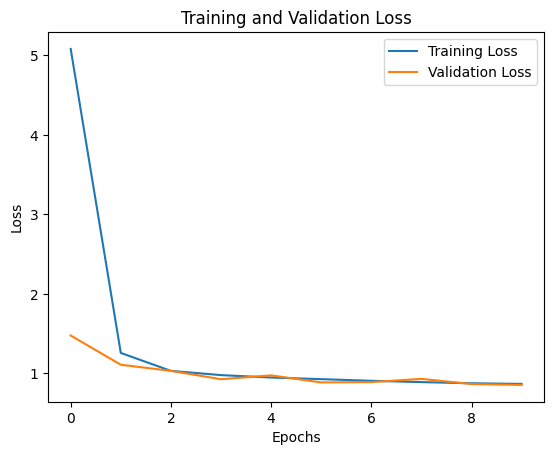

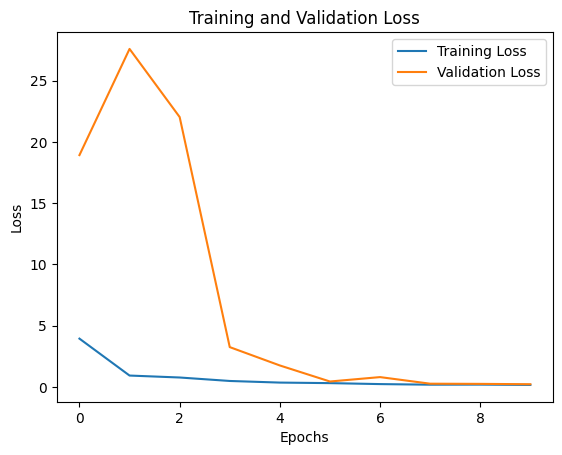

In [145]:
# Plot loss curves
plot_loss_curves(history_simple)
plot_loss_curves(history_optimized)

40/40 [==============================] - 1s 17ms/step
Evaluation Metrics:
Accuracy: 0.5430
Precision: 0.6132
Recall: 0.5430
F1 Score: 0.5297
Specificity: 1.0000
Sensitivity: nan


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19884\583065030.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


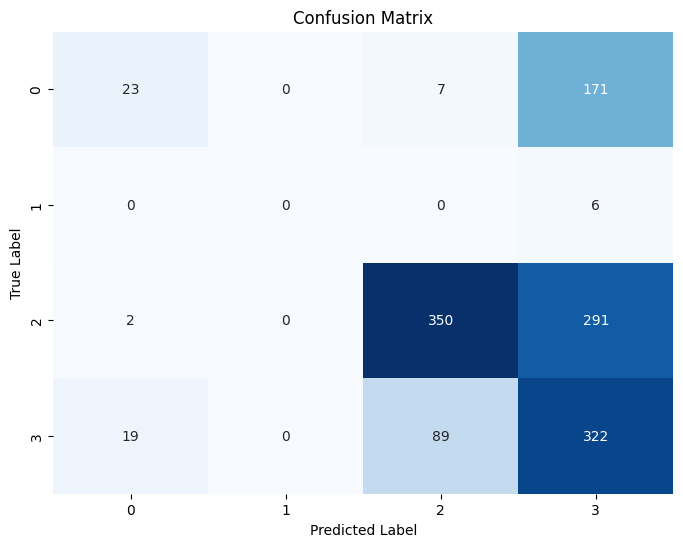

In [156]:
# Error Analysis on model without optimization
error_analysis(simple_model, X_test, y_test_encoded)

40/40 [==============================] - 4s 84ms/step
Evaluation Metrics:
Accuracy: 0.9430
Precision: 0.9448
Recall: 0.9430
F1 Score: 0.9433
Specificity: 1.0000
Sensitivity: 1.0000


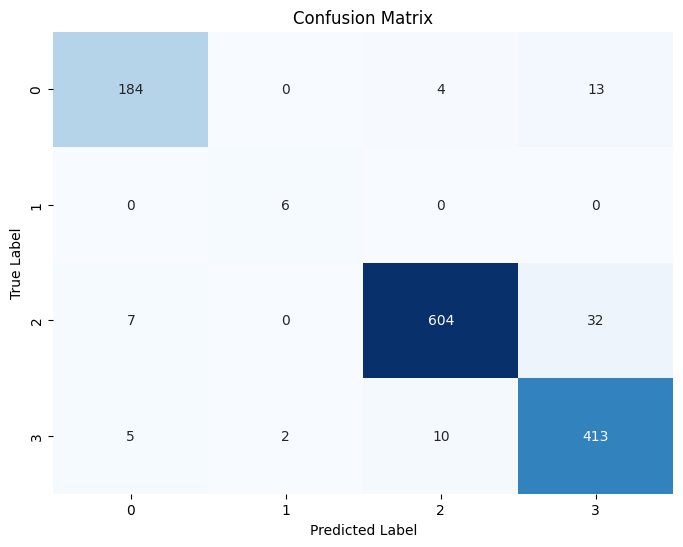

In [157]:
# Error Analysis on model with optimization
error_analysis(optimized_model, X_test, y_test_encoded)

1/1 [==============================] - 0s 31ms/step


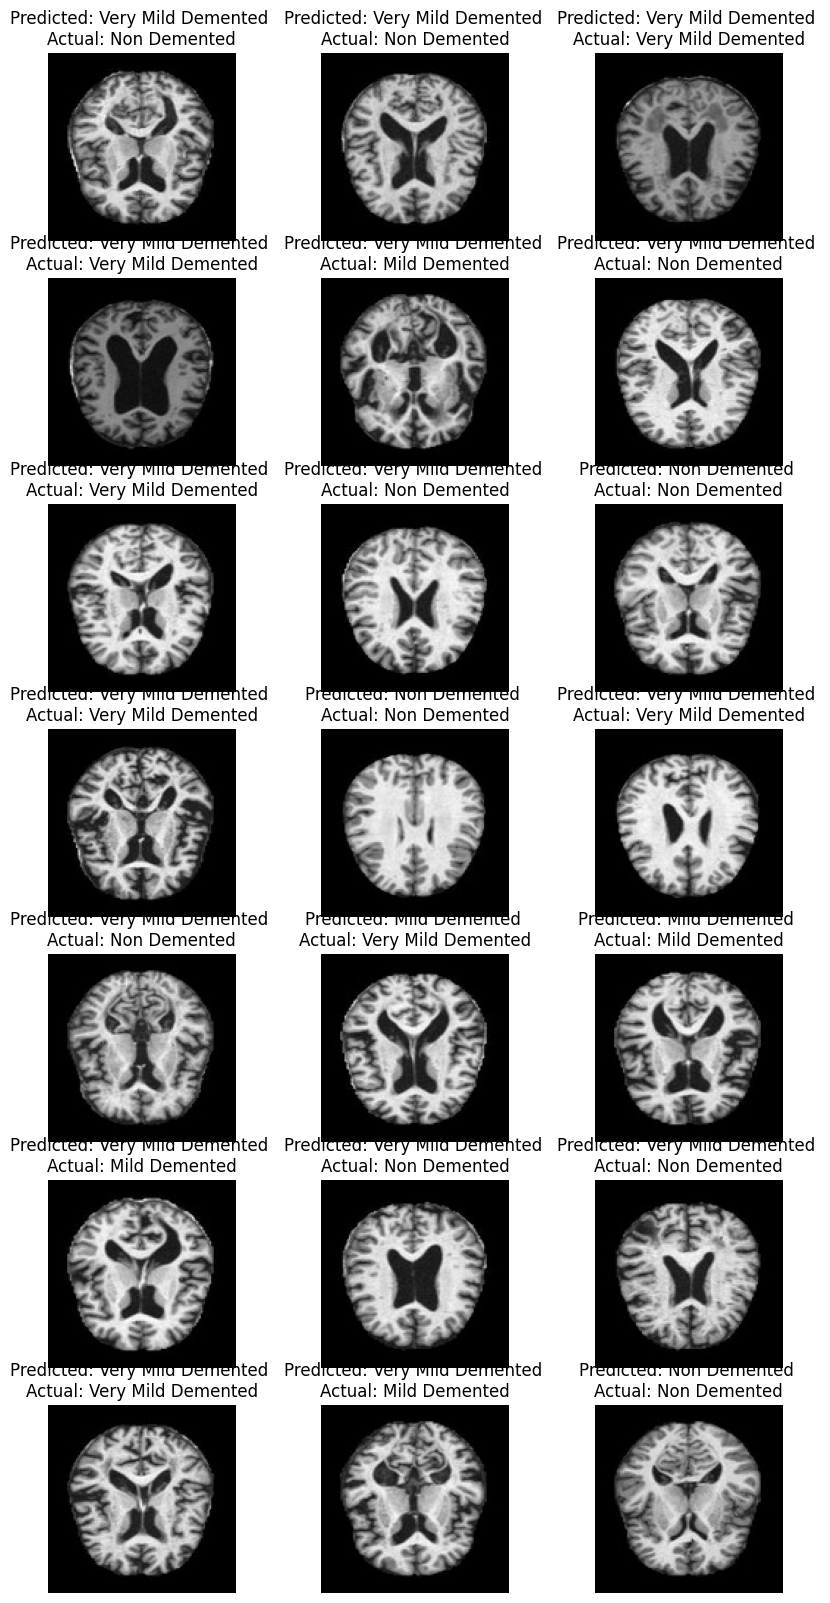

In [164]:
# Make predictions using the unoptimized model
predictions = simple_model.predict(X_test)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compare the predicted labels with the true labels
fig, axs = plt.subplots(7, 3, figsize=(10, 20))
axs = axs.flatten()

# Limit the number of images to the number of subplots
num_images = min(len(y_test_encoded), len(axs))

for i in range(num_images):
    axs[i].imshow(X_test[i])
    predicted_class_index = np.argmax(simple_model.predict(X_test[i:i+1]))  # Get the index of the highest probability class
    axs[i].set_title(f'Predicted: {classnames[predicted_labels[i]]} \nActual: {classnames[y_test_encoded[i]]}')
    axs[i].axis('off')

1/1 [==============================] - 0s 29ms/step


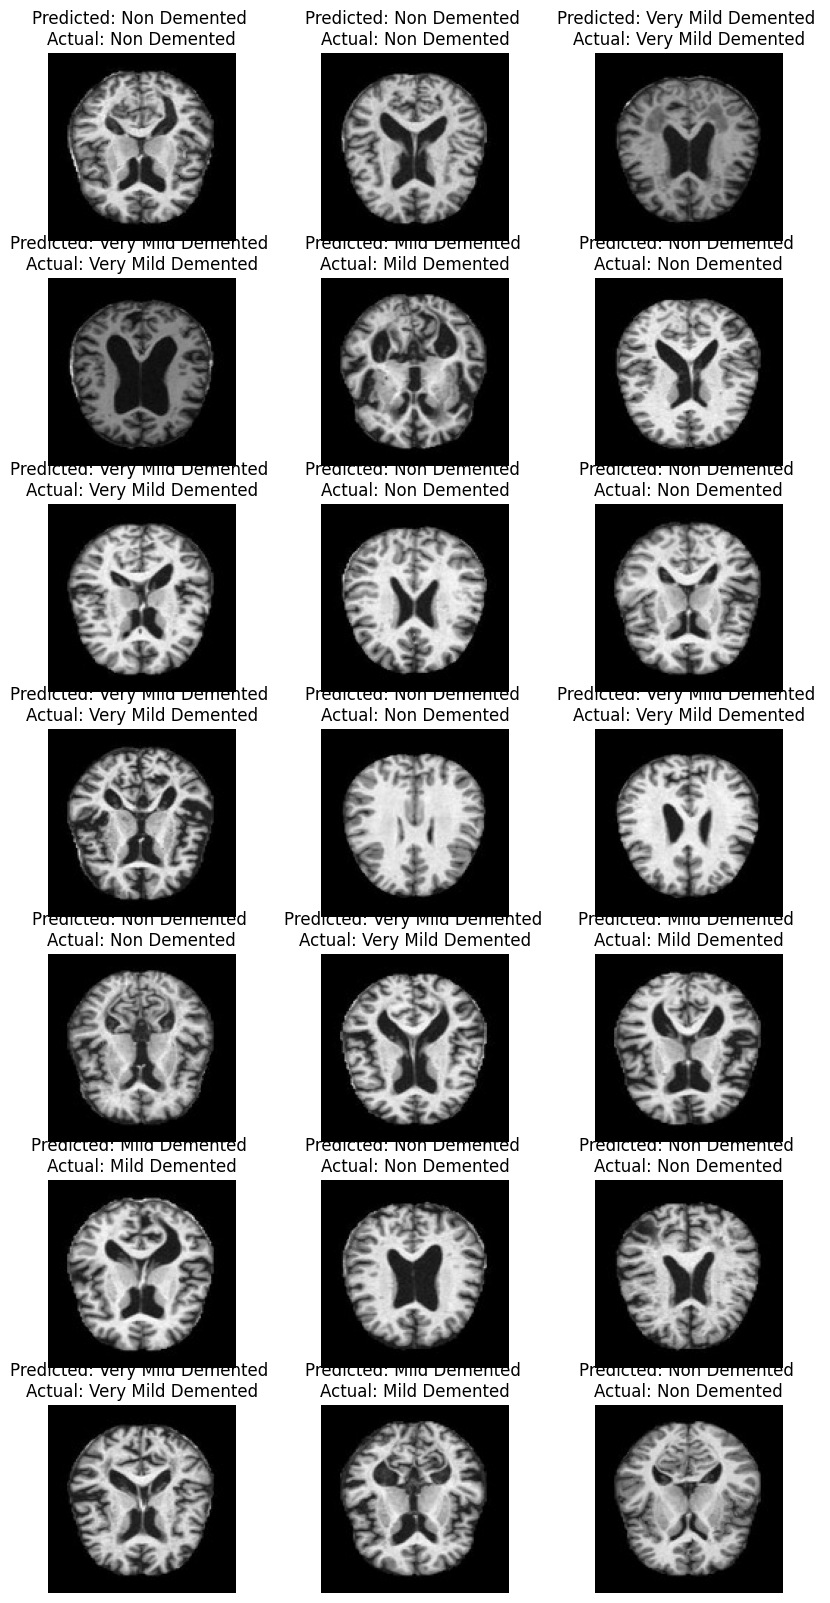

In [162]:
# Make predictions using the optimized model
predictions = optimized_model.predict(X_test)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compare the predicted labels with the true labels
fig, axs = plt.subplots(7, 3, figsize=(10, 20))
axs = axs.flatten()

# Limit the number of images to the number of subplots
num_images = min(len(y_test_encoded), len(axs))

for i in range(num_images):
    axs[i].imshow(X_test[i])
    predicted_class_index = np.argmax(simple_model.predict(X_test[i:i+1]))  # Get the index of the highest probability class
    axs[i].set_title(f'Predicted: {classnames[predicted_labels[i]]} \nActual: {classnames[y_test_encoded[i]]}')
    axs[i].axis('off')